In [8]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import pack_vis
import pack_dimer
import pack_vis_sol
import pack_io
import pack_cost
import numpy as np
import cupy as cp
import copy
import pandas as pd
import glob
kgs.set_float32(True)
kgs.debugging_mode = 2

In [9]:
%load_ext pyinstrument

The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument


In [10]:
# Preload reference data
ref_csvs = []
for csv_file in [kgs.code_dir + '../res/70.32.csv', kgs.code_dir + '../res/my_old_with_85.csv']:
    raw = pack_io.dataframe_to_solution_list(pd.read_csv(csv_file))
    ref_csvs.extend(raw[0])

tess_sols = kgs.dill_load(kgs.code_dir + '../res/tess_legalized.pickle')

ga_sols = []
for g in glob.glob(kgs.code_dir + '../res/ga_*.pickle'):
    sols = kgs.dill_load(g)
    ga_sols.extend(sols)

In [11]:
def collection_solutions(N_trees):
    sol_list = []
    
    # Reference solutions from CSVs
    for s in ref_csvs:
        if s.N_trees == N_trees:
            print('csv')
            sol_list.append(s.xyt)
    
    # Tessellation solution
    for s in tess_sols:
        if s.N_trees == N_trees:
            print('tess')
            sol_list.append(s.xyt)
    
    # GA solutions
    for s in ga_sols:
        if s.N_trees == N_trees:
            print('ga')
            sol_list.append(s.xyt)
    
    # Controller runs - all 4 patterns
    for pattern in [f'*runs/done/ga_N{N_trees}_*.pickle', 
                    f'*runs/extra/ga_N{N_trees}_*.pickle',
                    f'*runs/repro/ga_N{N_trees}_*.pickle',
                    f'rerun_done/done/ga_N{N_trees}_*.pickle']:
        for g in glob.glob(kgs.temp_dir + '/' + pattern):
            print(g)
            rr = kgs.dill_load(g)
            sol_list.append(rr.ga.champions[0].phenotype.xyt)
    
    sol_list = [x.astype(kgs.dtype_cp) for x in sol_list]
    for x in sol_list:
        assert isinstance(x, cp.ndarray)
        assert x.shape == (1,N_trees, 3)

    return sol_list
    
def create_exploit_ga(sol_list):
    ga = pack_ga3.baseline()
    

In [12]:
sol_list=collection_solutions(60)

csv
csv
tess
/mnt/d//packing/temp/controller_runs/done/ga_N60_seed110_done.pickle
/mnt/d//packing/temp/controller_runs/done/ga_N60_seed111_done.pickle
/mnt/d//packing/temp/controller_runs/done/ga_N60_seed112_done.pickle
/mnt/d//packing/temp/controller_runs/done/ga_N60_seed113_done.pickle
/mnt/d//packing/temp/controller_runs/done/ga_N60_seed114_done.pickle
/mnt/d//packing/temp/controller_runs/done/ga_N60_seed115_done.pickle
/mnt/d//packing/temp/controller_runs/done/ga_N60_seed116_done.pickle
/mnt/d//packing/temp/controller_runs/done/ga_N60_seed140_done.pickle
/mnt/d//packing/temp/controller_runs/done/ga_N60_seed141_done.pickle
/mnt/d//packing/temp/controller_runs/done/ga_N60_seed200_done.pickle
/mnt/d//packing/temp/controller_runs/done/ga_N60_seed201_done.pickle
/mnt/d//packing/temp/controller_runs/done/ga_N60_seed300_done.pickle
/mnt/d//packing/temp/controller_runs/done/ga_N60_seed500_done.pickle
/mnt/d//packing/temp/controller_runs/done/ga_N60_seed87_done.pickle
/mnt/d//packing/temp/c

In [15]:
import pack_ga3
importlib.reload(pack_ga3)
ga = pack_ga3.baseline()
ga_to_copy = ga.ga.ga_base
ga.ga.ga_base = None
ga.ga.ga_list = []
ga.ga.mate_distance = 100
#ga.ga.diversity_reset_threshold = np.inf
ga.ga.diversity_delete_instead_of_reset = True
for s in sol_list:
    this_ga = copy.deepcopy(ga_to_copy)    
    this_ga.fixed_h = None
    this_ga.N_trees_to_do = s.shape[1]
    sol = kgs.SolutionCollectionSquare()
    sol.xyt = s
    sol.snap()
    sol.h *= 1.01
    sol.use_fixed_h = True    
    this_ga.initializer = pack_ga3.InitializerFixed()
    this_ga.initializer.fixed_sol = sol
    this_ga.check_constraints()
    this_ga.reset_check_generations = 1000000
    this_ga.reset_check_generations_ratio = 100.
    this_ga.always_allow_mate_with_better = False
    ga.ga.ga_list.append(this_ga)
ga.diagnostic_plot = True
ga.plot_every = 10
#ga.n_generations = 10
ga.check_constraints()


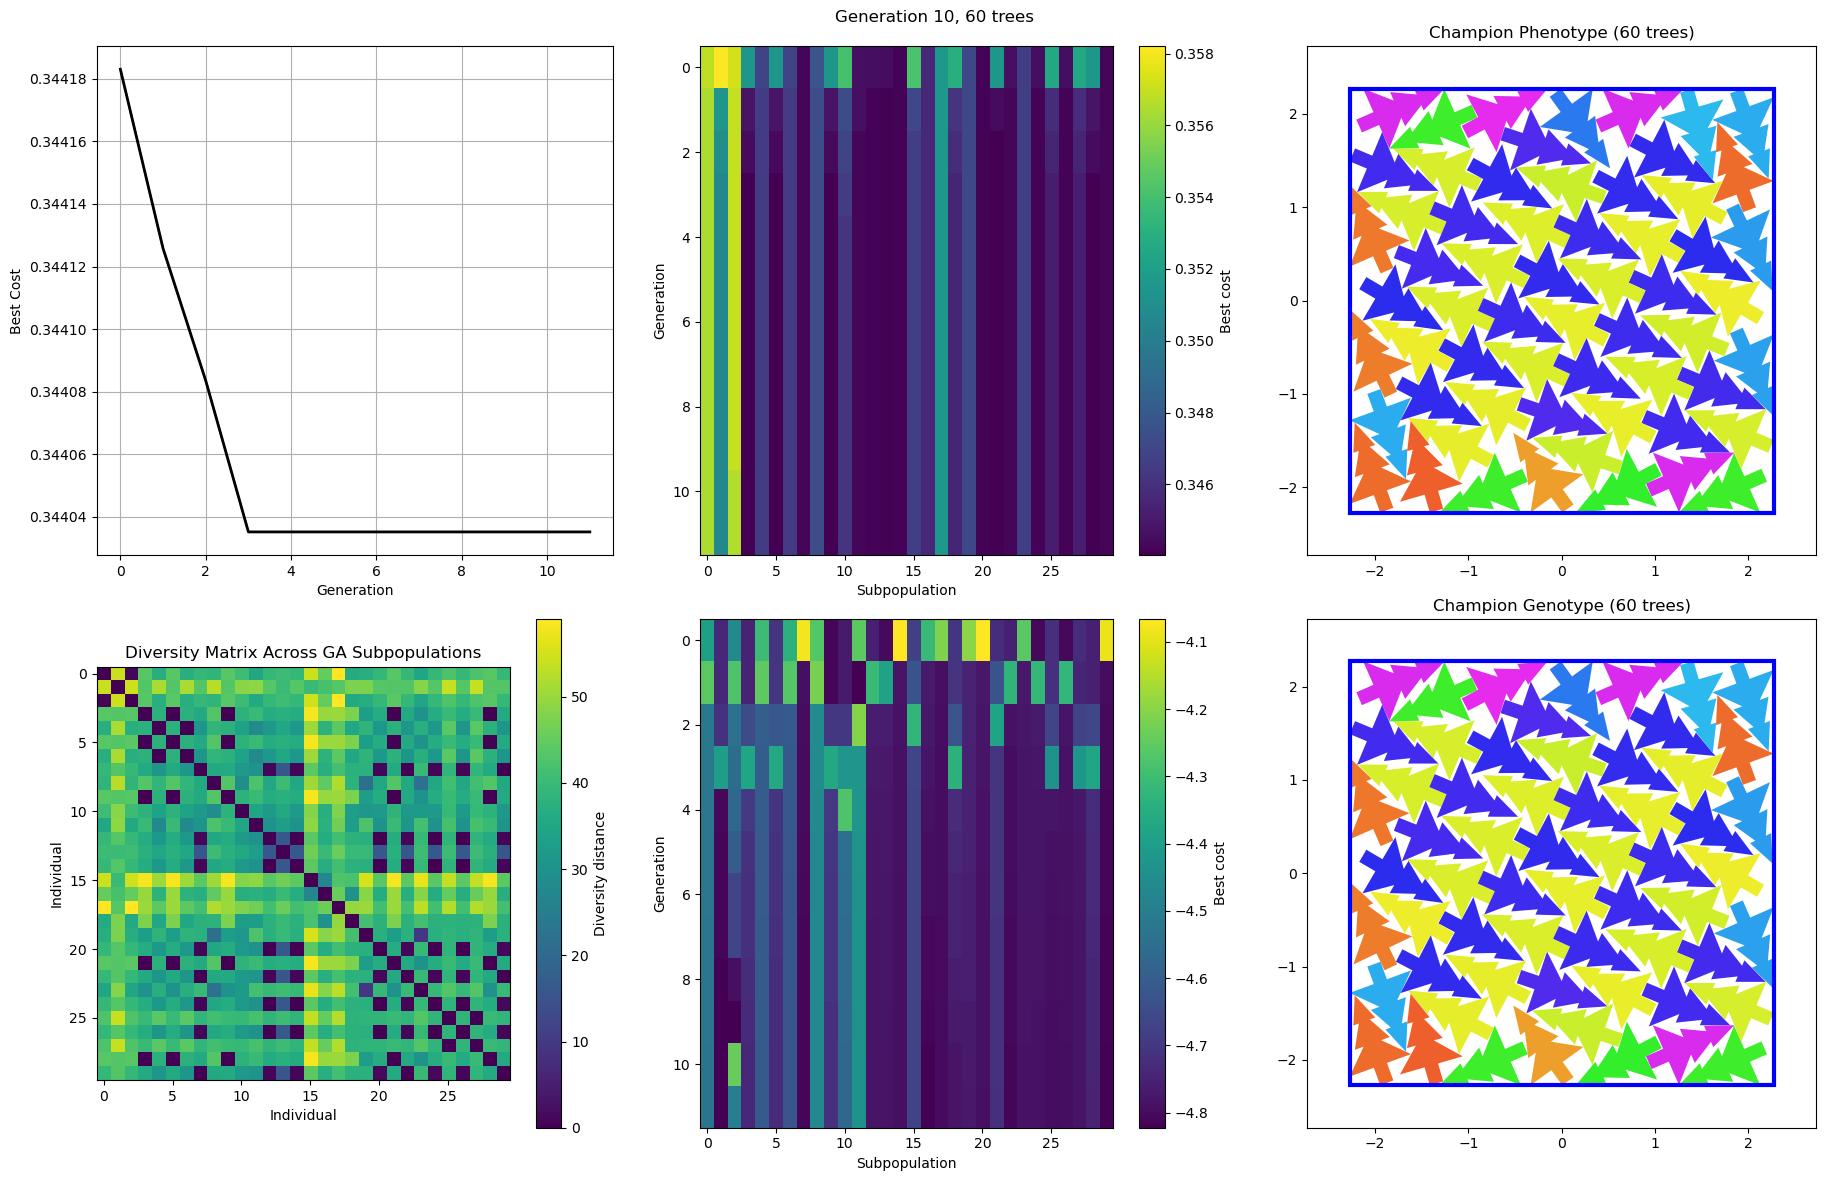

In [ ]:
ga.run()

In [ ]:
this_ga.always_allow_mate_with_better

False

In [1]:
2

2